<a href="https://colab.research.google.com/github/CZ-CE3004-MDP-Group10/rpi-cv/blob/main/TensorFlow_RPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Directory and Pathing Structure
Start by mounting the repository, this repository contains the labeled images and image preprocessing scripts

In [1]:
! git clone --depth 1 https://github.com/CZ-CE3004-MDP-Group10/rpi-cv

Cloning into 'rpi-cv'...
remote: Enumerating objects: 7014, done.
remote: Counting objects: 100% (7014/7014), done.
remote: Compressing objects: 100% (4220/4220), done.
remote: Total 7014 (delta 2766), reused 7005 (delta 2762), pack-reused 0
Receiving objects: 100% (7014/7014), 85.93 MiB | 29.57 MiB/s, done.
Resolving deltas: 100% (2766/2766), done.
Checking out files: 100% (6912/6912), done.


## Configure Environment Paths

In [2]:
# # copy github repo to working directory 
# %cp -a /content/rpi-cv/TensorFlow /content

In [3]:
TENSORFLOW_PATH = '/content/rpi-cv/TensorFlow'
TF_API_MODEL_PATH = TENSORFLOW_PATH + '/models' 
SCRIPTS_PATH = TENSORFLOW_PATH + '/scripts'
WORKSPACE_PATH = TENSORFLOW_PATH + '/workspace'
ANNOTATIONS_PATH = WORKSPACE_PATH + '/annotations'
IMAGES_PATH = WORKSPACE_PATH +'/images'
MODEL_PATH = WORKSPACE_PATH + '/models'
PRE_TRAINED_MODELS_PATH = WORKSPACE_PATH +'/pre-trained-models'

In [4]:
!mkdir {MODEL_PATH}
!mkdir {PRE_TRAINED_MODELS_PATH}

## Mount TensorFlow Model Garden
In order to use the TensorFlow Object Detection API, we need to clone it's GitHub Repo.

In [5]:
import os
os.chdir(TENSORFLOW_PATH)
os.getcwd()

!git clone --depth 1 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2449, done.
remote: Counting objects: 100% (2449/2449), done.
remote: Compressing objects: 100% (2043/2043), done.
remote: Total 2449 (delta 593), reused 1333 (delta 379), pack-reused 0
Receiving objects: 100% (2449/2449), 30.84 MiB | 31.94 MiB/s, done.
Resolving deltas: 100% (593/593), done.


## Set up TensorFlow Object Detection Environment
To use the object detection api we need to add it to our PYTHONPATH along with slim which contains code for training and evaluating several widely used Convolutional Neural Network (CNN) image classification models.

In [6]:
import os
import sys
os.environ['PYTHONPATH'] += ":/content/TensorFlow/models"
print(os.environ['PYTHONPATH'])

sys.path.append('/content/TensorFlow/models/research')
print(sys.path)

/env/python:/content/TensorFlow/models
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/TensorFlow/models/research']


# Install Required Libraries and Tools
With colab, TensorFlow is already pre-installed along with its other dependencies. 

However, the TensorFlow Object Detection API relies on what are called protocol buffers (also known as protobufs). Protobufs are a language neutral way to describe information. That means you can write a protobuf once and then compile it to be used with other languages, like Python, Java or C.

In [7]:
!sudo apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


## Build and Install the TensorFlow Object Detection API
The protoc command used below is compiling all the protocol buffers in the object_detection/protos folder for Python. 

In [8]:
import os
os.chdir(TF_API_MODEL_PATH+'/research')

# Compile and build the TF2 OD setup.py
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
# install TF2 OD API
!python -m pip install . --quiet 

     |████████████████████████████████| 9.0MB 9.7MB/s 
     |████████████████████████████████| 358kB 47.2MB/s 
     |████████████████████████████████| 1.1MB 54.8MB/s 
     |████████████████████████████████| 2.2MB 51.3MB/s 
     |████████████████████████████████| 829kB 47.1MB/s 
     |████████████████████████████████| 153kB 50.1MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 17.7MB 244kB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
     |████████████████████████████████| 706kB 42.1MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 1.2MB 42.1MB/s 
     |████████████████████████████████| 174kB 51.7MB/s 
     |████████████████████████████████| 645kB 42.2MB/s 
     |████████████████████████████████| 112kB 51.8MB/s 
ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3

## Test Tensorflow 2 Object Detection API

In [9]:
# import os
# os.chdir(TF_API_MODEL_PATH+'/research/object_detection/builders')

# !python model_builder_tf2_test.py # prints out run ok if TF2 OD API is installed successfully

# Model Training

## 1. Label Image with Imagelabel
Label the image according to their appropriate signs.

https://github.com/tzutalin/labelImg generates PASCAL .xml format of every images

## 2. Split Image Dataset
Using partition.py, we will split the dataset to a ratio of 9:1 for train & test

In [10]:
# specify dataset in image path
IMAGE_DATASET_PATH = IMAGES_PATH + '/dataset'

In [11]:
# get batch size
import fnmatch
image_count = len(fnmatch.filter(os.listdir(IMAGE_DATASET_PATH), '*.jpg'))
print(image_count)

655


In [12]:
!python3 {SCRIPTS_PATH}/preprocessing/partition.py -i {IMAGE_DATASET_PATH} -o {IMAGES_PATH} -x

## 2. Create Label Map
TensorFlow requires a label map, which namely maps each of the used labels to an integer values. This label map is used both by the training and detection processes.

In [13]:
labels = [
    {'name':'up', 'id':1}, 
    {'name':'down', 'id':2}, 
    {'name':'right', 'id':3}, 
    {'name':'left', 'id':4}, 
    {'name':'go', 'id':5}, 
    {'name':'6', 'id':6},
    {'name':'7', 'id':7}, 
    {'name':'8', 'id':8}, 
    {'name':'9', 'id':9}, 
    {'name':'0', 'id':10}, 
    {'name':'v', 'id':11}, 
    {'name':'w', 'id':12}, 
    {'name':'x', 'id':13}, 
    {'name':'y', 'id':14}, 
    {'name':'z', 'id':15}
]

with open(ANNOTATIONS_PATH+'/label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

## 3. Create TensorFlow Records

Now that we have generated our annotations and split our dataset into the desired training and testing subsets, it is time to convert our annotations into the so called TFRecord format.
Convert *.xml to *.record

To do this we can write a simple script that iterates through all *.xml files in the training_demo/images/train and training_demo/images/test folders, and generates a *.record file for each of the two. Here is an example script that allows us to do just that:

In [26]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[5][0].text),
                     int(member[5][1].text),
                     int(member[5][2].text),
                     int(member[5][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    os.chdir(IMAGES_PATH)
    image_path = os.path.join(os.getcwd(), 'train')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv(f'{ANNOTATIONS_PATH}/train.csv', index=None)
    print('Successfully converted xml to csv.')


main()

Successfully converted xml to csv.


In [14]:
# Create train data:
!python {SCRIPTS_PATH + '/preprocessing/generate_tfrecord.py'} -x {IMAGES_PATH + '/train'} -i {IMAGES_PATH + '/train'} -l {ANNOTATIONS_PATH + '/label_map.pbtxt'} -o {ANNOTATIONS_PATH + '/train.record'}

# Create test data:
!python {SCRIPTS_PATH + '/preprocessing/generate_tfrecord.py'} -x {IMAGES_PATH + '/test'} -l {ANNOTATIONS_PATH + '/label_map.pbtxt'} -o {ANNOTATIONS_PATH + '/test.record'}

Successfully created the TFRecord file: /content/rpi-cv/TensorFlow/workspace/annotations/train.record
Successfully created the TFRecord file: /content/rpi-cv/TensorFlow/workspace/annotations/test.record


## 4. Download Pre-Trained Model
To begin with, we need to download the latest pre-trained network for the model we wish to use. 

This can be done by simply clicking on the name of the desired model in the table found in [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Clicking on the name of your model should initiate a download for a `*.tar.gz` file.

Once the `*.tar.gz` file has been downloaded, open it using a decompression program of your choice (e.g. 7zip, WinZIP, etc.). Next, open the `*.tar` folder that you see when the compressed folder is opened, and extract its contents inside the folder `/workspace/pre-trained-models`. 

In [15]:
import os
import requests
import tarfile

from shutil import copyfile


os.chdir(PRE_TRAINED_MODELS_PATH)
base_url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/"
# model = "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz"
model = "ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"

url = f'{base_url}{model}'
r = requests.get(url, allow_redirects=True)
open(model, 'wb').write(r.content)
tar = tarfile.open(model)
tar.extractall()
tar.close()

## 4. Copy Choosen Model to Training folder
Finally, the object detection training pipeline must be configured. It defines which model and what parameters will be used for training. This is the last step before running training!

In [16]:
CUSTOM_MODEL_NAME = model.partition('.')[0]
CUSTOM_MODEL_NAME

'ssd_mobilenet_v2_320x320_coco17_tpu-8'

In [17]:
import os
from shutil import copyfile

os.chdir(WORKSPACE_PATH)
os.mkdir(MODEL_PATH + '/' + CUSTOM_MODEL_NAME)

copyfile(PRE_TRAINED_MODELS_PATH + '/' + CUSTOM_MODEL_NAME + '/pipeline.config', MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/pipeline.config')

'/content/rpi-cv/TensorFlow/workspace/models/ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config'

## 5. Updating Choosen Model Config file
There will be multiple parameters that needs to be configured for the config file prior to training. We will use a Python script to shorten the process.



In [18]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [19]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [20]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [21]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

In [22]:
# Number of label classes
pipeline_config.model.ssd.num_classes = 15
# Number of Batch size based on memory space
pipeline_config.train_config.batch_size = 32
# Model checkpoint (Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model)
pipeline_config.train_config.fine_tune_checkpoint = PRE_TRAINED_MODELS_PATH + '/' +CUSTOM_MODEL_NAME + '/checkpoint/ckpt-0' 
# Specify to train DETECTION model
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
# Label map for train
pipeline_config.train_input_reader.label_map_path= ANNOTATIONS_PATH + '/label_map.pbtxt'
# TF records of train
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATIONS_PATH + '/train.record']
# Label map for test
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATIONS_PATH + '/label_map.pbtxt'
# TF reocrds of test
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATIONS_PATH + '/test.record']

In [23]:
# write changes to config
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)

## Train the Model

In [24]:
# Begin training
! python {TF_API_MODEL_PATH}/research/object_detection/model_main_tf2.py \
    --model_dir={MODEL_PATH}/{CUSTOM_MODEL_NAME} \
    --pipeline_config_path={CONFIG_PATH} \
    --alsologtostderr

2021-03-09 21:13:22.345259: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-03-09 21:13:27.651615: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-03-09 21:13:27.688950: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-03-09 21:13:27.766044: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-03-09 21:13:27.766182: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f5eccda95d22): /proc/driver/nvidia/version does not exist
2021-03-09 21:13:27.767862: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
W0309 21:13:27.779336 140550826125184 cross_device_ops.py:1321] There are no

In [ ]:
#save checkpoints after each run to drive
# !cp -a /content/TensorFlow/workspace/models/ssd_mobilenet_v2_320x320_coco17_tpu-8/ /content/drive/MyDrive/CV/01

cp: cannot create directory '/content/drive/MyDrive/CV/01': No such file or directory


In [ ]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [ ]:
CHECKPOINT_PATH = MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/'

In [ ]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-6')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

NotFoundError: ignored

# Try Image detection by passing in image



In [ ]:
import cv2 
import numpy as np

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATIONS_PATH+'/label_map.pbtxt')

/content/TensorFlow/workspace/images


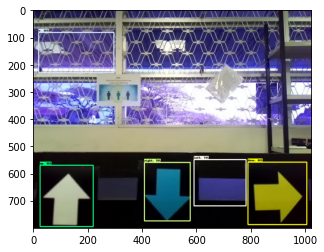

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
 
#frame = cv2.imread(IMAGES_PATH+"/test/50_set_1_174.jpg")
frame = cv2.imread(IMAGES_PATH+"/test/test_20.jpg")
print(IMAGES_PATH)
image_np = np.array(frame)
 
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}

detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
 
label_id_offset = 1
image_np_with_detections = image_np.copy()
 
viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.1,
            agnostic_mode=False)


plt.imshow(cv2.cvtColor(cv2.resize(image_np_with_detections, (1024, 800)), cv2.COLOR_BGR2RGB))
plt.show()